In [461]:
import os
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import xml.etree.ElementTree as ET
import json
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw
import random

import mrcnn.model as modellib
import mrcnn.visualize as visualize
import mrcnn.config as config
import mrcnn.utils as utils

import warnings
warnings.filterwarnings("ignore")

#import random
#import math

In [462]:
class FacesConfig(config.Config):
    NAME = "Faces"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 4

In [463]:
config = FacesConfig()

In [464]:
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [447]:
class FacesDataset(utils.Dataset):
    """Dataset class for faces dataset"""
    
    def __init__(self, images_list,annotations_path, dataset_dir):
        super().__init__(self)
        
        # Add classes
        self.add_class('Faces', 1, 'face')
        self.add_class('Faces', 2, 'nose')
        self.add_class('Faces', 3, 'mouth')
        self.images_data = self.load_images_data(annotations_path) ## RENAME TO ANNOTATIONS

        # Add images
        
        for i, filename in enumerate(images_list):
            images = self.images_data['images']
            for img in images:
                if img['file_name'] == filename:
                    img_id = img['id']
                    fp = os.path.join(dataset_path, filename)
                    img_h = img['height']
                    img_w = img['width']
                    self.add_image('Faces',
                                   image_id=img_id,
                                   path=fp,
                                   height=img_h,
                                   width=img_w)
                    
        self.add_annotations()

        
    def image_reference(self, image_id):
        for img in self.image_info:
            if img['id'] == image_id:
                return img['path']
        return None
    
    
    def load_images_data(self, filepath):
        """JSON format annotations"""
        with open (filepath) as file:
            info = json.load(file)
        
        return info
    
    
    def add_annotations(self):
        for i,image in enumerate(self.image_info):
            img_id = image['id']
            segments = [] 
            cat_ids = []
            for img_ann in self.images_data['annotations']:
                if img_id == img_ann['image_id']:
                    segments.append(img_ann['segmentation'][0])
                    cat_ids.append(img_ann['category_id'])
            self.image_info[i]['cat_ids'] = cat_ids
            self.image_info[i]['segments'] = segments
            
        
    def load_mask(self, image_id):
        assert image_id in self.image_ids, 'id not valid'
        
        info = self.image_info[image_id]
        h = info['height']
        w = info['width']
        count = len(info['cat_ids'])
        
        class_ids = np.zeros((count,), dtype=np.int32)
        mask = np.zeros((h,w, count), dtype=np.uint8)
                
        for i, s in enumerate(info['segments']):
            class_ids[i] = info['cat_ids'][i]
            x_s = s[::2]
            y_s = s[1::2]
            rr, cc = skimage.draw.polygon(y_s, x_s)

            mask[rr,cc,i] = 1
        
        return mask, class_ids
        
        
        
        for img in self.image_info:
            if img['id'] == image_id:
                h = img['height']
                w = img['width']
                count = len(img['cat_ids'])
        
                class_ids = np.zeros((count,), dtype=np.int32)
                mask = np.zeros((h,w, count), dtype=np.uint8)
                
                for i, s in enumerate(img['segments']):
                    class_ids[i] = img['cat_ids'][i]
                    x_s = s[::2]
                    y_s = s[1::2]
                    rr, cc = skimage.draw.polygon(y_s, x_s)

                    mask[rr,cc,i] = 1
        
                return mask, class_ids
    
    
    ## USE RESIZE IMAGE utils.Dataset.resize_image?? and resize_mask
    ## only work with masks for now, do not annotate further until first round of training and testing

In [451]:
annots_path = os.path.abspath('annots/polygons_20.json')

In [452]:
dataset_path = os.path.abspath('./images/labeled')

In [469]:
model_path = os.path.abspath('models')

In [453]:
images_list = os.listdir(dataset_path)
random.seed(42)
random.shuffle(images_list)
val_size = 5
images_val = images_list[:val_size]
images_train = images_list[val_size:]
print(len(images_train), len(images_val))

15 5


In [454]:
# Training set
dataset_train = FacesDataset(images_train, annots_path, dataset_path)
dataset_train.prepare()
print('Train %d' % len(dataset_train.image_ids))

Train 15


In [455]:
# Validation set
dataset_val = FacesDataset(images_val, annots_path, dataset_path)
dataset_val.prepare()
print('Test %d' % len(dataset_val.image_ids))

Test 5


In [456]:
dataset_train.image_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

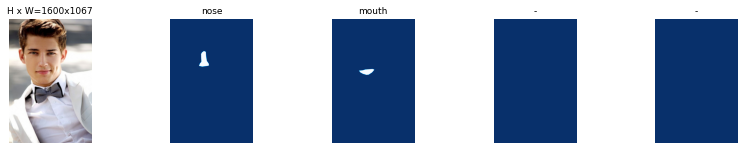

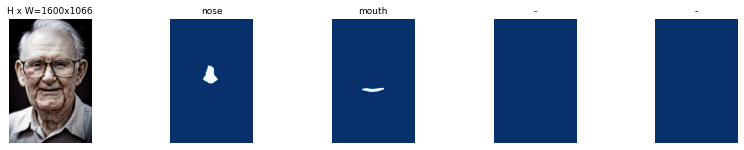

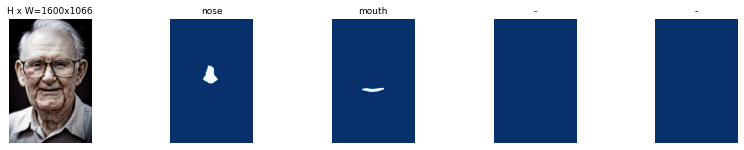

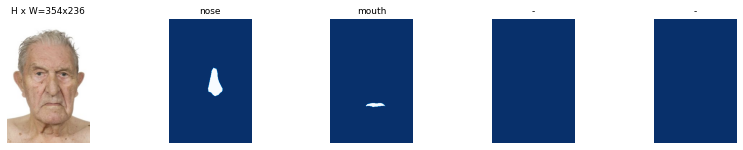

In [460]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids,4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [470]:
model = modellib.MaskRCNN(mode='training',
                             config=config,
                             model_dir=model_path)

In [471]:
model.load_weights(filepath='mask_rcnn_coco.h5', by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=2,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: E:\PersonalProjects\FaceDetect\models\faces20220828T1548\mask_rcnn_faces_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
m